## Algoritmo genético aplicado al problema de optimización de portafolios con restricción de cardinalidad

El problema de optimización de cartera con restricción de cardinalidad consiste en: 

Sea:
- $N$: número de activos disponibles.
- $K$ : número deseado de activos en el portafolio.
- $\epsilon_i$: proporción mínima que se debe mantener del activo $i$ si el activo $i$ se mantiene. Representa el nivel mínimo de transacción.
- $\delta_i$: proporción máxima que se debe mantener del activo $i$ si el activo $i$ se mantiene. Limita la exposición de la cartera al activo $i$.
- $$z_i = \left\lbrace\begin{array}
1 & ~si~se~ mantiene ~el~ activo~i\\
0 & ~ en~ otro~ caso
\end{array}\right.$$


Minimizar

$$\lambda[\sum_{i=1}^{N}\sum_{j=1}^{N}w_iw_j \sigma_{ij}]-(1-\lambda)[\sum_{i=1}^{N}w_i\mu_i]$$

Sujeto a:

$\sum_{i=1}^{N} w_i =1$

$\sum_{i=1}^{N} z_i =K$

$\epsilon_i z_i \leq w_i \leq \delta_iz_i,~~i=1,...,N$

$z_i \in [0,1], ~~i = 1,...,N$


## Código

#### Importe de librerías

In [1]:
import numpy as np
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')
drive_path= "/content/drive/My Drive/Optimizacion/Datasets/"

Mounted at /content/drive


#### Función que crea los datos de entrada

La función *create_data_input* crea el diccionario que recibe como dato de entrada la función *GA*, la cual que recrea el algoritmo genético. El diccionario consiste en:

- *n* : Total de activos
- *mean_list* : La lista del promedio y la desviación estándar de los rendimientos de los activos 
- *covariance* : Matriz de varianzas y covarianzas de los rendimientos de los activos 
- *epsilon* : Arreglo de las proporciones mínimas de los activos
- *delta* : Arreglo de las proporciones máximas de los activos

Por lo tanto, la función *create_data_input* recibe como parámetros la lista  del promedio y la desviación estándar de los rendimientos de los activos, la matriz de covarianzas y los arreglos de las proporciones mínimas y máximas. 

In [3]:
def create_data_input(assets_mean,covariance_matrix, epsilon, delta):
    data = {
        'n': len(assets_mean), # Total de activos
         # La lista del promedio y la desviación estándar de los rendimientos de los activos 
        'mean_list':  assets_mean, 
        'covariance': covariance_matrix, # Matriz de varianzas y covarianzas
        'epsilon': epsilon, # Arreglo de las proporciones mínimas de los activos
        'delta' : delta # Arreglo de las proporciones máximas de los activos
    }
    return data

#### Funciones creadas para utilizar dentro del algoritmo genético:

- Función *evaluate*:

La función *evaluate* asegura que las posibles soluciones sean factibles. Recibe como  parámetros el número de activos deseado $K$, el cromosoma $S$, el parámetro de ponderación $\lambda$ y devuelve el cromosoma $S$ con los valores $s_i$ reestablecidos para que sea factible y el valor de la función objetivo para la solución $S$.

La solución $S$ es el cromosoma que consiste en:
- $Q$ : es el conjunto de $K$ activos distintos de la solución actual
- $s$: vector de los valores de la proporción libre del portafolio que corresponde a los activos pertenientes a $Q$.
- $epsilon$: vector de las proporciones mínimas de los activos pertenientes a $Q$.
- $delta$: vector de las proporciones máximas de los activos pertenientes a $Q$.
- $ W $:  vector de las proporciones $w$  correspondientes a los activos pertenientes a $Q$.

In [35]:
def evaluate(data, K,  S, lambda_):

  N = data['n'] # Número total de activos
  p = len(S['Set']) # Tamaño de la población 

  f = [np.inf for _ in range(p)] # Inicializa el vector f, que guarda el valor de la función objetivo de cada cromosoma

  # Para cada solución (cromosoma) de la población
  for i in range(p):
    
    # # Verifica si la solución es infactible. En caso de serlo, genera otros cromosomas hasta encontrar uno factible.
    # while np.sum( S['Set'][i]['epsilon'])>1 or np.sum( S['Set'][i]['delta'])<1:
    #   muestra_K = np.random.choice(range(N), K, replace=False) #Genera la combinación de $K$ activos diferentes
    #   S['Set'][i]['Q'] =  muestra_K # Guarda los índices de los activos pertenecientes a Q
    #   S['Set'][i]['s'] = np.random.uniform(size = K ) #Genera aleatoriamente los valores $s_i$
    #   S['Set'][i]['epsilon'] = data['epsilon'][ muestra_K ] #Guarda los valores de epsilon de los activos pertenecientes a Q
    #   S['Set'][i]['delta'] = data['delta'][ muestra_K ] ##Guarda los valores de delta de los activos pertenecientes a Q

    S['Set'][i]= {key: np.array(value) for key, value in S['Set'][i].items()} #Convierte en arreglo cada elemento de S

    L =  np.sum( S['Set'][i]['s'] ) # L es la suma de todas las s
    F = 1 - np.sum( S['Set'][i]['epsilon'] )  # F es la proporción libre del portafolio 

    # Calcula las proporciones para satisfacer epsilon y sumar 1 
    S['Set'][i]['W'] = S['Set'][i]['epsilon'] + S['Set'][i]['s']*F/L

    # Vector booleano que resulta de comparar w > delta
    exceeded = S['Set'][i]['W'] > S['Set'][i]['delta']
    
    # Procedimiento iterativo para satisfacer proporciones máximas:
    # Si  w > delta para algún activo, se itera hasta volverse factible
    while np.sum(exceeded)!=0:
        
      # Se calcula la suma de s para los activos que satisfacen las proporciones mínimas
      L = np.sum( S['Set'][i]['s'][np.where(~exceeded)[0]] )
    
     # Se calcula la porporción libre del portafolio
      F = 1- np.sum( S['Set'][i]['epsilon'][np.where(~exceeded)[0]] ) + np.sum( S['Set'][i]['delta'][np.where(exceeded)[0]] ) 
      
     # # Se calcula las proporciones w para los activos que satisfacen las proporciones mínimas
      S['Set'][i]['W'][np.where(~exceeded)[0]] = S['Set'][i]['epsilon'][np.where(~exceeded)[0]] +  (F/L)*S['Set'][i]['s'][np.where(~exceeded)[0]]
      
      # Para los activos que no satisfacen las proporciones mínimas, se establece para w el límite
      S['Set'][i]['W'][np.where(exceeded)[0]] = S['Set'][i]['delta'][np.where(exceeded)[0]]  
    
      # Se calcula nuevamente el lector booleano que resulta de comparar w > delta
      exceeded = S['Set'][i]['W'] > S['Set'][i]['delta']

    # Calcula el rendimiento esperado del conjunto Q de K activos.
    Q = S['Set'][i]['Q']
    mean = np.array([data['mean_list'][index] for index in Q])
    
    # Calcula el riesgo del conjunto Q de K activos.
    w = np.zeros(N)
    w[Q] = S['Set'][i]['W']
    #w = np.array(w)
    var_sum  = w@data['covariance']@w.reshape(-1,1) 

    # Se calcula la aptitud
    f[i] = lambda_*var_sum - (1-lambda_)*np.sum( mean*S['Set'][i]['W'] )

     # Verifica si la solución es infactible. En caso de serlo, establece el valor de infito a la función objetivo
    if np.sum( S['Set'][i]['epsilon'])>1 or np.sum( S['Set'][i]['delta'])<1:
      f[i]=np.inf
    
    # Se reestablece s
    S['Set'][i]['s'] = S['Set'][i]['W'] - S['Set'][i]['epsilon']

  return S, f



- Función *binary_tournament_selection*:

Los padres fueron elegidos por selección de torneo binario que
funciona formando dos grupos de individuos conformados por dos individuos extraídos de la
población al azar. Cada padre es extraído del individuo con mayor aptitud de cada grupo (menor función objetivo).

La función recibe como datos de entrada el cromosoma $S$, el vector $f$ de los valores de la función objetivo de los cromosomas y el tamaño de la población $p$. La función devuelve los cromosomas de los padres.

In [8]:
def binary_tournament_selection(S, f, p):

    num_candidates = p # Tamaño de la población

    # Se forman dos grupos de torneos seleccionando al azar dos individuos de la población
    pool1 = np.random.choice(range(num_candidates), 2, replace=False)
    pool2 = np.random.choice(range(num_candidates), 2, replace=False)

    # Se obtienen los valores de aptitud de los individuos en cada grupo
    fitness_pool1 = [f[individual] for individual in pool1]
    fitness_pool2 = [f[individual] for individual in pool2]
 
    # Se selecciona a los padres con la mejor aptitud de cada grupo
    parent1_index = pool1[fitness_pool1.index(min(fitness_pool1))]
    parent2_index = pool2[fitness_pool2.index(min(fitness_pool2))]

    parent1 = S['Set'][parent1_index]
    parent2 = S['Set'][parent2_index]

    return parent1, parent2


- Función *uniform_crossover*:

La Función *uniform_crossover* aplica el cruce mediante el método uniforme para crear un único hijo. Cada activo se elige de cualquiera de los padres con igual probabilidad. La función recibe como parámetros los cromosomas de los padres  y tasa de cruce, que en este caso es $0.5$ por default. La función devuelve el cromosoma del hijo y el cromosoma $A$, que contiene todos los activos no heredados de los padres. 

In [9]:
def uniform_crossover(S1, S2, crossover_rate=0.5):
  K =  len(S1['Q']) # Número de activos deseados

  # Crea el diccionario que representa el cromosoma del hijo
  child = {'Set':[]} 
  child['Set'].append({'Q':[], 's':[], 'epsilon':[], 'delta':[], 'W': []})
    
  # Crea el diccionario que representa el cromosoma A, que contiene todos los activos no heredados de los padres
  A = {'Q':[], 's':[], 'epsilon':[], 'delta':[], 'W':[]}

  # Vector booleano que determina los activos que se heredan del primer padre. 
  # El negativo de este vector determina los activos que se heredan del segundo padre. 
  index = np.random.uniform(low=0.0, high=1.0, size= K ) < crossover_rate

  # Se guardan los elementos obtenidos para el cromosoma del hijo
  child['Set'][0]['Q'] = list(S1['Q'][index]) + list(S2['Q'][~index])
  child['Set'][0]['s']  = list(S1['s'][index]) + list(S2['s'][~index])
  child['Set'][0]['epsilon'] = list(S1['epsilon'][index]) + list(S2['epsilon'][~index])
  child['Set'][0]['delta']= list(S1['delta'][index]) + list(S2['delta'][~index])
  child['Set'][0]['W'] = list(S1['W'][index]) + list(S2['W'][~index])

  # Como el hijo pudo haber heredado un activo más de una vez, se guarda en una lista los elementos únicos (sin repetición)
  unique_child_Q = []
  unique_child_s = []
  unique_child_epsilon = []
  unique_child_delta = []
  unique_child_W = []

  seen = set()
  for elem1, elem2, elem3, elem4, elem5 in zip(child['Set'][0]['Q'], child['Set'][0]['s'], child['Set'][0]['epsilon'], child['Set'][0]['delta'], child['Set'][0]['W']):
    if elem1 not in seen:
      unique_child_Q.append(elem1)
      unique_child_s.append(elem2)
      unique_child_epsilon.append(elem3)
      unique_child_delta.append(elem4)
      unique_child_W.append(elem5)
      seen.add(elem1)
        
  # Se guardan los elementos únicos obtenidos para el cromosoma del hijo
  child['Set'][0]['Q'] = unique_child_Q
  child['Set'][0]['s'] = unique_child_s
  child['Set'][0]['epsilon'] = unique_child_epsilon
  child['Set'][0]['delta'] = unique_child_delta
  child['Set'][0]['W'] = unique_child_W
    
  # Se guardan los elementos no obtenidos para el cromosoma del hijo, es decir, los elementos no heredados de los padres
  leftover_Q = list(S1['Q'][~index]) + list(S2['Q'][index])
  leftover_s  = list(S1['s'][~index]) + list(S2['s'][index])
  leftover_epsilon = list(S1['epsilon'][~index]) + list(S2['epsilon'][index])
  leftover_delta = list(S1['delta'][~index]) + list(S2['delta'][index])
  leftover_W  = list(S1['W'][~index]) + list(S2['W'][index])
    
  # Como el puede haber elementos repetidos en el conjunto de elementos heredados,
  # se guarda en una lista los elementos únicos (sin repetición)
  unique_leftover_Q = []
  unique_leftover_s = []
  unique_leftover_epsilon = []
  unique_leftover_delta = []
  unique_leftover_W = []

  seen = set()
  for elem1, elem2, elem3, elem4, elem5 in zip(leftover_Q, leftover_s, leftover_epsilon, leftover_delta, leftover_W):
    if elem1 not in seen:
      unique_leftover_Q.append(elem1)
      unique_leftover_s.append(elem2)
      unique_leftover_epsilon.append(elem3)
      unique_leftover_delta.append(elem4)
      unique_leftover_W.append(elem5)
      seen.add(elem1)
        
  # Se guardan los elementos únicos obtenidos para el cromosoma A
  A['Q']= [x for x in  unique_leftover_Q if x not in child['Set'][0]['Q']]
  A['s']= [unique_leftover_s[unique_leftover_Q.index(x)] for x in  unique_leftover_Q if x not in child['Set'][0]['Q']]
  A['epsilon']= [unique_leftover_epsilon[unique_leftover_Q.index(x)] for x in  unique_leftover_Q if x not in child['Set'][0]['Q']]
  A['delta']= [unique_leftover_delta[unique_leftover_Q.index(x)] for x in  unique_leftover_Q if x not in child['Set'][0]['Q']]
  A['W']= [unique_leftover_W[unique_leftover_Q.index(x)] for x in  unique_leftover_Q if x not in child['Set'][0]['Q']]

  return child, A

#### Función que recrea el algoritmo genético:

La función *GA* recibe como parámetros el diccionario de los datos de entrada, el cromosoma $S$, el número $E$ de parámetros $\lambda$ que se desean examinar, el tamaño de la población $p$ y el número máximo de iteraciones (*max_iter*).

La función devuelve la mejor solución para cada $\lambda$ determinado. Cada solución es un diccionario que contiene:
- *Valor de lambda*
- *fitness*: La aptitud de la solución, es decir, el valor de la función objetivo
- *weight*: Las proporciones $w_i$
- *mean_port*: El rendimiento esperado del portafolio.
- *risk_port*: El riesgo del portafolio.


In [43]:
def GA(data, K, E,  p = 100, max_iter =1000):

  N = data['n'] # Nímero de activos disponibles

  best_solution = {'lambda':[]} # Diccionario que guarda las mejores soluciones paa cada lambda

  # Para cada lambda:
  for e in range(E):
    lambda_ = e/(E-1) # Examina E números de lambdas igualmente espaciados en [0,1]

    best_solution['lambda'].append({'Valor de lambda':[], 'portfolio':0, 'fitness':0,  'weight':[], 'mean_port':[], 'risk_port':[] })
    best_solution['lambda'][e]['Valor de lambda'] = lambda_ 

    # Crea aleatoriamente el p cromosomas S
    S = {'Set':[]}

    for i in range(p):
      S['Set'].append({'Q':[], 's':[], 'epsilon':[], 'delta':[], 'W':[] })
      muestra_K = np.random.choice(range(N), K, replace=False)
      S['Set'][i]['Q'] =  muestra_K
      S['Set'][i]['s'] = np.random.uniform(size = K )
      S['Set'][i]['epsilon'] = data['epsilon'][ muestra_K ]
      S['Set'][i]['delta'] = data['delta'][ muestra_K ]
      S['Set'][i]['W'] = np.zeros(K)
    
    # Evalúa los cromosomas, garantizando que sean factibles y devolviendo el vector f de los valores la función objetivo
    S, f  = evaluate(data, K,  S, lambda_)

    # Para cada iteración:
    for _ in range(max_iter):
        
      # Se aplica el método de selección por torneo binario
      S1, S2 = binary_tournament_selection(S, f, p)
        
      # Se realiza el cruce de los padres por el método uniforme
      C, A = uniform_crossover(S1, S2, crossover_rate=0.5)

      # Elige aleatoriamente un activo i del cromosoma
      i = np.random.choice(range(len(C['Set'][0]['Q'])), 1, replace=False)[0]  
      m = np.random.choice([1,2], 1, replace=False)
    
      # Se realiza el proceso de mutación
      if m==1:
        C['Set'][0]['s'][i] = 0.9*( C['Set'][0]['epsilon'][i] + C['Set'][0]['s'][i]) - C['Set'][0]['epsilon'][i]
      else:
        C['Set'][0]['s'][i] = 1.1*( C['Set'][0]['epsilon'][i] + C['Set'][0]['s'][i]) - C['Set'][0]['epsilon'][i]

      # Si el valor s mutado es negativo, se elimina el activo  i del conjunto Q
      if C['Set'][0]['s'][i] < 0:
        for key in C['Set'][0]:
          del C['Set'][0][key][i]

      # Mientras la cardinalidad del conjunto Q sea mayor a K, se eliminan los activos con menor valor s
      while len( C['Set'][0]['Q']) > K:
        min_index = C['Set'][0]['s'].index(min(C['Set'][0]['s']))       
        
        for key in C['Set'][0]:
          del C['Set'][0][key][min_index]
        
      # Mientras la cardinalidad del conjunto Q sea menor a K: 
      while len( C['Set'][0]['Q']) < K:
        
        # Se toma aleatoriamente un activo j (junto con sus valores asociados) del cromosoma A, que contiene los activos no heredados
        if len(A['Q'])!=0:
          j = np.random.choice(A['Q'], 1, replace=False)[0]
          index_j = A['Q'].index(j)
          for key in C['Set'][0]:
            C['Set'][0][key].append(A[key][index_j])
            del A[key][index_j]
            
        # Si el conjunto Q del cromosoma A está vacio, se toma aleatoriamente un activo j (junto con sus valores asociados) diferente del conjunto disponible
        else:
          child_Q_set = set(C['Set'][0]['Q'])
        
          j = np.random.choice(range(N), 1, replace=False)[0]   
          while j in child_Q_set: 
            j = np.random.choice(range(N), 1, replace=False)[0]
          
          C['Set'][0]['Q'].append(j)
          C['Set'][0]['s'].append(0)
          C['Set'][0]['epsilon'].append(data['epsilon'][j])
          C['Set'][0]['delta'].append(data['delta'][j])
          C['Set'][0]['W'].append(0)                              
            
      # Ahora que el conjunto Q del hijo tiene exactamente K activos, se procede a aplicar la evaluación
      C, fc  = evaluate(data,K, C, lambda_)
      
      # Encuentra al peor miembro de la población
      worse_population_member = f.index(max(f))

      # Reemplaza al peor miembro de la población por el hijo
      for key in S['Set'][worse_population_member]:
          S['Set'][worse_population_member][key] = C['Set'][0][key]

      f[worse_population_member]= fc[0]
    
    # Encuentra al mejor miembro de la población
    min_fitness = min(f) # Obtiene la mejor aptitud
    best_member_index = f.index(min_fitness) # Obtiene el índice del mejor cromosoma 
    best_Q = S['Set'][best_member_index]['Q'] # Guarda el conjunto Q del mejor cromosoma 

    # Obtiene las medias de los rendimientos de los activos del conjunto Q del mejor cromosoma 
    mean_port = np.array([data['mean_list'][index] for index in best_Q])
    
    # Calcula el riesgo del conjunto de Q del mejor cromosoma 
    W_port = np.zeros(N)
    W_port[best_Q] = S['Set'][best_member_index]['W']
    W_port = np.array(W_port)
    risk_port = W_port@data['covariance']@W_port.reshape(-1,1)
    
    # Guarda los resultados del mejor cromosoma para el lambda dado.
    best_solution['lambda'][e]['portfolio'] =  best_Q
    best_solution['lambda'][e]['fitness'] =  min_fitness
    best_solution['lambda'][e]['weight'] = S['Set'][ best_member_index ]['W']
    best_solution['lambda'][e]['mean_port'] = np.sum(mean_port*W_port[best_Q])
    best_solution['lambda'][e]['risk_port'] = np.sqrt(risk_port[0])

  return best_solution


#### Función que calcula la frontera eficiente del problema de optimización de portafolio sin restricciones:

In [45]:
#--------------------------El siguiente código calcula la frontera eficiente de un portafolio de inversiones
#--------------------------correspondiente a la misma base de datos de 31 acciones, esta vez se pinta el punto de varianza mínima-------
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Definimos la función objetivo y las restricciones
def objective_function(weights, cov_matrix):
    return np.sum(np.dot(weights, cov_matrix) * weights)

def constraint_return(weights, expected_returns, target_return):
    return np.sum(np.dot(weights, expected_returns)) - target_return

def constraint_sum(weights):
    return np.sum(weights) - 1.0

def optimize_portfolio(expected_returns, cov_matrix, target_return):
    num_assets = len(expected_returns)
    initial_weights = np.ones(num_assets) / num_assets  # starting with equal weights

    bounds = [(0, 1) for _ in range(num_assets)]  # non-negative weights constraint

    constraints = [{'type': 'eq', 'fun': constraint_return, 'args': (expected_returns, target_return)},
                   {'type': 'eq', 'fun': constraint_sum}]

    options = {'disp': False, 'iprint': 0}

    result = minimize(objective_function, initial_weights, args=(cov_matrix,), method='SLSQP',
                      bounds=bounds, constraints=constraints, options=options)
    optimized_weights = result.x
    optimized_risk = np.sqrt(np.dot(optimized_weights, np.dot(cov_matrix, optimized_weights)))

    return optimized_weights, optimized_risk


def plot_efficient_frontier(expected_returns, cov_matrix):
    num_assets = len(expected_returns)
    target_returns = np.linspace(np.min(expected_returns), np.max(expected_returns), num_assets)
    efficient_risks = []

    for target_return in target_returns:
        weights, risk = optimize_portfolio(expected_returns, cov_matrix, target_return)
        efficient_risks.append(risk)

    efficient_risks = np.array(efficient_risks)  # Convertir a array NumPy

    # Encontrar el índice del mínimo riesgo
    idx_min_risk = np.argmin(efficient_risks)

    # Acotar la curva desde el mínimo riesgo
    efficient_risks = efficient_risks[idx_min_risk:]
    target_returns = target_returns[idx_min_risk:]

    # Graficar la frontera eficiente acotada
    plt.figure(figsize=(10, 6))
    plt.plot(efficient_risks, target_returns, c='blue', label='Frontera Eficiente')
    plt.scatter(efficient_risks[0], target_returns[0], c='red', label='Cartera de Mínima Varianza')
    plt.xlabel('Riesgo')
    plt.ylabel('Rendimiento Esperado')
    plt.title('Frontera Eficiente')
    plt.grid(True)
    plt.legend()
    plt.show()

    return efficient_risks, target_returns



#### Función que grafica la frontera eficiente:

In [47]:
def efficient_frontier_graph(K, mean_set, risk_set):

  import matplotlib.pyplot as plt
  plt.scatter(risk_set, mean_set, label = "K = "  + str(K))
  plt.xlabel('Riesgo - Desviación estándar')
  plt.ylabel('Retorno')
  plt.title('Frontera eficiente')
  plt.legend()
  plt.show()


### Ejemplo 1

Lectura de los datos de 31 acciones:

In [11]:
file_path ='port1.txt'
with open(file_path, 'r') as file:
    content = file.read()

lines = content.splitlines()
lines

tuple_list = []
for string in lines:
    nums = string.split()  # Split the string by space
    float_nums = tuple(float(num) for num in nums)  # Convert substrings to floats and create a tuple
    tuple_list.append(float_nums)

n = int(tuple_list[0][0])
mean = tuple_list[1:(n+1)]
mean=[x[0] for x in mean]
corr = tuple_list[(n+1):len(tuple_list)]

#matriz de correlacion
correlation_matrix = np.zeros((n,n))
for i in range(len(corr)):
  correlation_matrix[int(corr[i][0]-1),int(corr[i][1]-1)] = corr[i][2]
  correlation_matrix[int(corr[i][1]-1),int(corr[i][0]-1)] = corr[i][2]

std_devs = np.sqrt(np.diag(correlation_matrix))
covariance_matrix = correlation_matrix * np.outer(std_devs, std_devs)

A continuación, se muestra frontera eficiente sin restricciones.

In [ ]:
risks_N31, returns_N31 = plot_efficient_frontier(mean, covariance_matrix ) # Puntos de la 

Para aplicar el algoritmo genético, primero se crean los datos de entrada.

In [41]:
epsilon = np.zeros(len(mean))
#epsilon= np.array([0.01]*len(mean))
delta_unos =  np.ones(len(mean))
data = create_data_input(mean,covariance_matrix, epsilon, delta_unos)


Se aplica el algoritmo genético:

In [44]:
%%time

N = data['n']
solucion = GA(data, K= N , E=50 ,  p = 100, max_iter =1000*N)

CPU times: user 25min 52s, sys: 59.3 s, total: 26min 52s
Wall time: 28min 32s


In [ ]:
solucion

In [48]:
mean_set = np.array( [item['mean_port'] for item in solucion['lambda']] ) # Conjunto de las medias obtenidas por el algoritmo genético
risk_set = np.array( [item['risk_port'] for item in solucion['lambda']] ) # Conjunto de los riesgos obtenidos por el algoritmo genético


Para el caso de $K=N$, se compara el resultado obtenido mediante el algoritomo genético y mediante porgramación cuadrática.

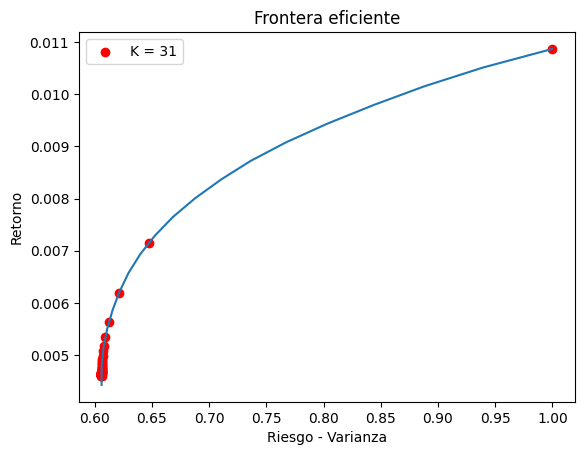

In [50]:
K = N
plt.scatter(risk_set, mean_set, label = "K = "  + str(K), color = 'red')
plt.plot(risks_N31, returns_N31 )
plt.xlabel('Riesgo - Varianza')
plt.ylabel('Retorno')
plt.title('Frontera eficiente')
plt.legend()
plt.show()

### Ejemplo 2

In [ ]:
#Ejemplo de codigo para una base de datos en la que se consideran índices de 50 empresas diferentes en un periodo de 3 años"
#-------------El siguiente código considera una base datos de 50 índices de empresas en un periodo de 3años--
#-------------Se grafica la frontera eficiente y se pinta el punto de mínima varianza----------------------

# Obtener los expected_returns y la matriz de covarianzas
symbols = [
    'AAPL', 'GOOGL', 'MSFT','DAX', 'AMZN', 'JPM', 'V', 'JNJ', 'WMT', 'PG',
    'MA', 'UNH', 'NVDA', 'VZ', 'DIS', 'HD', 'BAC', 'T', 'PYPL', 'PFE',
    'INTC', 'ADBE', 'TSLA', 'CMCSA', 'KO', 'MRK', 'NFLX', 'CRM', 'CSCO', 'XOM',
    'PEP', 'ABBV', 'ABT', 'CVX', 'ORCL', 'MCD', 'TSM', 'IBM', 'HON', 'AMGN',
    'NKE', 'ACN', 'TXN', 'SAP', 'BMY', 'SIEGY', 'TM', 'BA', 'GSK', 'SNY'
] 
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize

#Definimos la función objetivo:

 #La función objetivo toma como argumentos los pesos de asignación de los activos en el portafolio
  # y la matriz de covarianza de los retornos de los activos
  #La función calcula la varianza del portafolio: calculando el producto punto entre el vector de pesos
  # y la matriz de cov. posteriormente calcula la suma ponderada de los elementos resultantes.
def objective_function(weights, cov_matrix):
    return np.sum(np.dot(weights, cov_matrix) * weights)

# Definimos las constricciones:

# Restricción que calcula la suma ponderada de los rendimientos esperados
 #Se define de tal forma que la suma ponderada de los rendimientos esperados sea igual al rendimiento deseado, con el objetivo de cumplir connun determinado nivel de rendimiento objetivo.
def constraint_return(weights, expected_returns, target_return):
    return np.sum(weights * expected_returns) - target_return

#Restricción que define a la suma de los pesos igual a 1
#Permite asegurar que se invierta todo el capital disponible en el portafolio resultante.
def constraint_sum(weights):
    return np.sum(weights) - 1.0

#Esta función optimiza el portafolio de inversiones
def optimize_portfolio(expected_returns, cov_matrix, target_return):
    num_assets = len(expected_returns)#Longitud de los rendimientos esperados
    #Inicializa los pesos permitiendo que todos los activos tengan pesos iguales
    initial_weights = np.ones(num_assets) / num_assets  # starting with equal weights

#Restricciones:
    
    #Garantiza que no existan pesos negativos
    bounds = [(0, 1) for _ in range(num_assets)] 

   #Garantiza que el rendimiento del portafolio sea igual al rendimiento objetivo deseado
    constraints = [{'type': 'eq', 'fun': constraint_return, 'args': (expected_returns, target_return)},
                   {'type': 'eq', 'fun': constraint_sum}]#Restricción  que garantiza que la suma de los pesos de asignación sea igual a 1.

    options = {'disp': False, 'iprint': 0}#suprime los mensajes de impresión


    #función que permite encontrar los pesos de asignación óptimos para el portafolio, minimizando la función objetivo sujeta a las restriciiones dadas
    #Usa SLSQP para encontrar los pesos óptimos
    result = minimize(objective_function, initial_weights, args=(cov_matrix,), method='SLSQP',
                      bounds=bounds, constraints=constraints, options=options)
    optimized_weights = result.x #Pesos óptimos
    optimized_objective = result.fun #Valor óptimo de la función objetivo

    return optimized_weights, optimized_objective

import pandas as pd
import yfinance as yf

def get_expected_returns_and_covariance(symbols, save_to_file=False):
    data = yf.download(symbols, start='2019-01-01', end='2022-01-01')['Adj Close']
    returns = data.pct_change().dropna()
    expected_returns = returns.mean()
    cov_matrix = returns.cov()

    if save_to_file == True:
        returns.to_csv('returns_List50.csv')  # Guardar los retornos en un archivo CSV
        cov_matrix.to_csv('covariance_List50.csv')  # Guardar la matriz de covarianza en un archivo CSV

    return expected_returns, cov_matrix

# Obtener los expected_returns y la matriz de covarianzas y guardarlos en archivos CSV

expected_returns, cov_matrix = get_expected_returns_and_covariance(symbols, save_to_file=True)


def plot_efficient_frontier(expected_returns, cov_matrix):
    num_assets = len(expected_returns)
    target_returns = np.linspace(min(expected_returns), max(expected_returns), 100)
    efficient_objectives = []

    for target_return in target_returns:
        weights, objective = optimize_portfolio(expected_returns, cov_matrix, target_return)
        efficient_objectives.append(objective)

    minimum_objective_index = np.argmin(efficient_objectives)
    minimum_objective = efficient_objectives[minimum_objective_index]
    minimum_return = target_returns[minimum_objective_index]

    plt.figure(figsize=(10, 6))
    plt.scatter(efficient_objectives, target_returns, c='blue', label='Frontera Eficiente')
    plt.scatter(minimum_objective, minimum_return, c='red', label='Minimum Variance')
    plt.xlabel('Riesgo')
    plt.ylabel('Rendimiento Esperado')
    plt.title('Frontera Eficiente')
    plt.grid(True)
    plt.legend()
    plt.show()

    return efficient_objectives,target_returns

[*********************100%***********************]  50 of 50 completed


[*********************100%***********************]  50 of 50 completed


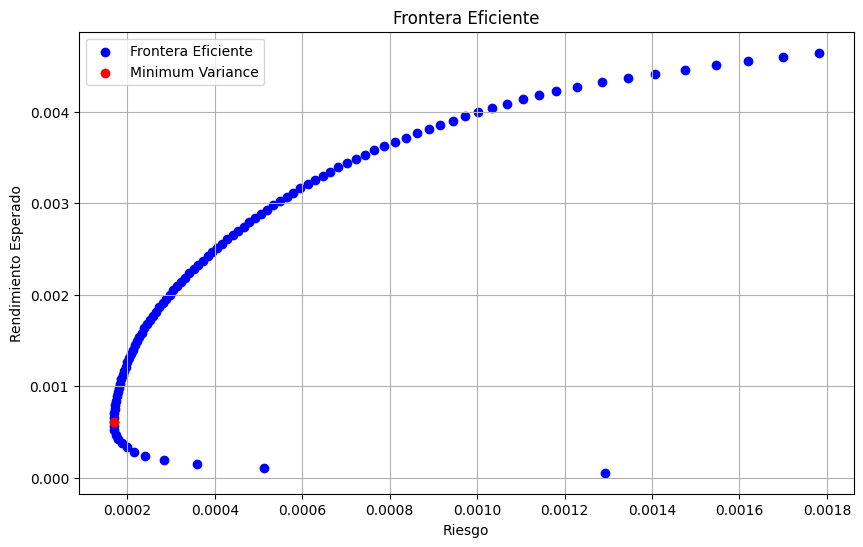

In [ ]:
# Obtener los expected_returns y la matriz de covarianzas
symbols = [
    'AAPL', 'GOOGL', 'MSFT','DAX', 'AMZN', 'JPM', 'V', 'JNJ', 'WMT', 'PG',
    'MA', 'UNH', 'NVDA', 'VZ', 'DIS', 'HD', 'BAC', 'T', 'PYPL', 'PFE',
    'INTC', 'ADBE', 'TSLA', 'CMCSA', 'KO', 'MRK', 'NFLX', 'CRM', 'CSCO', 'XOM',
    'PEP', 'ABBV', 'ABT', 'CVX', 'ORCL', 'MCD', 'TSM', 'IBM', 'HON', 'AMGN',
    'NKE', 'ACN', 'TXN', 'SAP', 'BMY', 'SIEGY', 'TM', 'BA', 'GSK', 'SNY'
] # Ejemplo de símbolos de acciones
expected_returns, cov_matrix = get_expected_returns_and_covariance(symbols)

# Optimizar y graficar la frontera eficiente
risks_N50,returns_N50 = plot_efficient_frontier(expected_returns, cov_matrix)

Para aplicar el algoritmo genético, primero se crean los datos de entrada.

In [ ]:
import pandas as pd
import numpy as np
returns = pd.read_csv("returns_List50-2.csv",header=None).to_numpy()
covariance = pd.read_csv("covariance_List50-2.csv",header=None).to_numpy()
returns =  returns[1:, 1:]
returns = returns.astype(np.float)
returns = np.mean(returns, axis=0)

covariance = covariance[1:, 1:]
covariance = covariance.astype(np.float)

In [36]:
epsilon_ceros = np.zeros(len(returns))
delta_unos =  np.ones(len(returns))
data2 = create_data_input(returns,covariance, epsilon_ceros, delta_unos)

Se aplica el algoritmo genético:

In [ ]:
%%time
N = 50
solucion2 = GA(data2, K=10, E= 50,  p = 100, max_iter =1000*N)

CPU times: user 11min 52s, sys: 49.6 s, total: 12min 41s
Wall time: 12min 21s


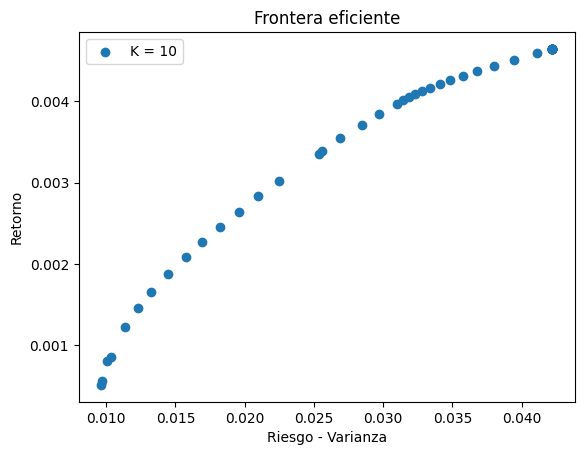

In [ ]:
mean_set2 = np.array( [item['mean_port'] for item in solucion2['lambda']] )
risk_set2 = np.array( [item['risk_port'] for item in solucion2['lambda']] )
efficient_frontier_graph(10, mean_set2, risk_set2)